# Imports
* To render properly on github click on the the small negative sign on the right side inside a circle and then choose `external view available with nbviewer`.

In [1]:
%matplotlib notebook
import sys, os, time, h5py, sys, pickle, matplotlib, random  
sys.path.insert(0, "/home/ruthvik/Desktop/Summer 2017/SpikeFlow")
os.environ["CUDA_VISIBLE_DEVICES"]="-1"  ### GPU is not used
import numpy as np
import spikeflow as sf
from spikeflow import network as network
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from spikeflow import inputlayerclass as inputlayer
np.random.seed(0)
from IPython.display import display, HTML

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters




Prepping the MNIST data .... 

Finished MNIST data ..

Prepping the EMNIST data .... 

Finished EMNIST data ..

Prepping the CIFAR100 data .... 

Unable to find data in AllDataSets/cifar100..
Prepping the CIFAR10 data .... 

Unable to find data in AllDataSets/cifar10..


# Hide code

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Encoding input data (L1)
* You can load a stored spike data or encode a new dataset
* To encode, place the files either in the `AllDataSets` folder.
* Follow the README in the `AllDataSets` folder for more info.

In [3]:
T1 = time.time()
tsteps = 12
test_frac = 1.0/7
val_frac=test_frac
data_set = 'emnist'
labels_map = {0:'0',1:'1',2:'2',3:'3',4:'4',5:'5',6:'6',7:'7',8:'8',9:'9',10:'A',11:'B',12:'C',13:'D',14:'E',15:'F',
              16:'G',17:'H',18:'I',19:'J',20:'K',21:'L',22:'M',23:'N',24:'O',25:'P',26:'Q',27:'R',28:'S',29:'T',30:'U',
             31:'V',32:'W',33:'X',34:'Y',35:'Z',36:'a',37:'b',38:'d',39:'e',40:'f',41:'g',42:'h',43:'n',44:'q',45:'r',
             46:'t'}
l1_maps = 30
sample_interval=200
nofImages = 6000
saved_data = True
intervals = nofImages/sample_interval
if(saved_data):
    #NOTE THAT ONLY TRAIN SPIKES AND LABELS ARE LOADED
    filename ='../../spiking_networks/emnist_train_on_x.h5'
    with h5py.File(filename, 'r') as hf:
        on_sparse = hf['on_time_tensor'][:]
    filename ='../../spiking_networks/emnist_train_off_x.h5'
    with h5py.File(filename, 'r') as hf:
        off_sparse = hf['off_time_tensor'][:]
    on_sparse = np.split(on_sparse, range(12,on_sparse.shape[-1],tsteps), axis = 2)
    on_sparse = np.concatenate(on_sparse, axis=-1)

    off_sparse = np.split(off_sparse, range(12,off_sparse.shape[-1],tsteps), axis = 2)
    off_sparse = np.concatenate(off_sparse, axis=-1)
    train_input_images = np.zeros((27,27,2,12*112799),dtype = np.bool_)
    train_input_images[:,:,0,:] = on_sparse
    train_input_images[:,:,1,:] = off_sparse
    filehandle = open('../../spiking_networks/emnist_train_y.pkl','rb')
    class_labels_train = pickle.load(filehandle).astype(np.int).tolist()
    filehandle.close()
    
if(not saved_data):
            #### grabbing testing data ###########
    firstLayer = inputlayer.InputLayer(debug= not True,size=27,dataset=data_set,off_threshold=50,\
                                       on_threshold=50,border_size=2,data='test',val_frac = val_frac,test_frac =test_frac)
    test_input_data = firstLayer.EncodedData()   ### data is in this format [(data_tensor1, data_label1), (data_tensor2, data_label2), .......]


            #### grabbing training data ###########
    firstLayer = inputlayer.InputLayer(debug= not True,size=27,dataset=data_set,off_threshold=50,\
                                       on_threshold=50,border_size=2,data='train',val_frac = val_frac,test_frac = test_frac)
    train_input_data = firstLayer.EncodedData()   ### data is in this format [(data_tensor1, data_label1), (data_tensor2, data_label2), .......]


            #### grabbing validation data ###########
    firstLayer = inputlayer.InputLayer(debug= not True,size=27,dataset=data_set,off_threshold=50,\
                                       on_threshold=50,border_size=2,data='valid',val_frac = val_frac,test_frac = test_frac)
    valid_input_data = firstLayer.EncodedData()   ### data is in this format [(data_tensor1, data_label1), (data_tensor2, data_label2), .......]



            ##### combine the training and validation data so that the classifier class can split it inside the keras library #######
    train_input_data.extend(valid_input_data)
    random.shuffle(train_input_data)

           ###### convert the vectorized labels to integer values #######
    class_labels_train = map(lambda x: np.where(x[1]==1)[1][0], train_input_data)
    class_labels_test = map(lambda x: np.where(x[1]==1)[1][0], test_input_data)


    temp_input_data = [items[0] for items in train_input_data][0:nofImages]
    temp_input_data = np.concatenate(temp_input_data,axis=3)
    train_input_images = temp_input_data

def fillspikes(image):
    locs = np.where(image==1)
    image[locs[0],locs[1],:]=1
    return image



# Train the first convolution layer (L2)

In [4]:
nTrain_images = nofImages
net1 = network.Network(homeostasis_const=5, factor=3.0, pool_lateral_inh=False, output_channels=l1_maps, \
            inputs=train_input_images[:,:,:,0:12*nTrain_images], A_plus=0.002, debug=False, \
            sample_interval=sample_interval, train=True, save_pool_spike_tensor=False, save_pool_features=False,\
            homeo_supp_coeff=0.003, threshold=15.0,lr_inc_rate=500)
net1.feedforward()
plots = True




Setting up the synapses and the weights

connections of first neuron in the maps to neurons in input image(prev_map):
[  0   1   2   3   4  27  28  29  30  31  54  55  56  57  58  81  82  83
  84  85 108 109 110 111 112]

connections of last neuron in the maps to neurons in input image(prev_map):
[616 617 618 619 620 643 644 645 646 647 670 671 672 673 674 697 698 699
 700 701 724 725 726 727 728]

There are:(27, 27) neurons in each of the input map and there are:25 synapses from previous maps going into each        neuron of the input map and there are:2 previous maps and there are:30 input maps
Images trained so far:1
current A_plus:0.004, A_minus:0.003, tstep:0, epoch:0


Images trained so far:500
current A_plus:0.008, A_minus:0.006, tstep:5999, epoch:0


Images trained so far:1000
current A_plus:0.016, A_minus:0.012, tstep:11998, epoch:0


Images trained so far:1500
current A_plus:0.032, A_minus:0.024, tstep:17997, epoch:0


Images trained so far:2000
current A_plus:0.064, A_minus:0.048, tstep:23996, epoch:0


Images trained so far:2500
current A_plus:0.128, A_minus:0.096, tstep:29995, epoch:0


Images trained so far:3000
current A_plus:0.15, A_minus:0.1125, tstep:35994, epoch:0


Images trained so far:3500
current A_plus:0.15, A_minus:0.1125, tstep:41993, epoch:0


Images trained so far:4000
current A_plus:0.15, A_minus:0.1125, tstep:47992, epoch:0


Images trained so far:4500
current A_plus:0.15, A_minus:0.1125, tstep:53991, epoch:0


Images trained so far:5000
current A_plus:0.15, A_minus:0.1125, tstep:59990, epoch:0


Images trained so far:5500
current A_plus:0.15, A_minus:0.1125, tstep:65989, epoch:0


Images trained so far:6000
current A_plus:0.15, A_minus:0.1125, tstep:71988, epoch:0
Epoch:0 is done!


## Plot and visualize filters in first convolution layer (L2)

<IPython.core.display.Javascript object>


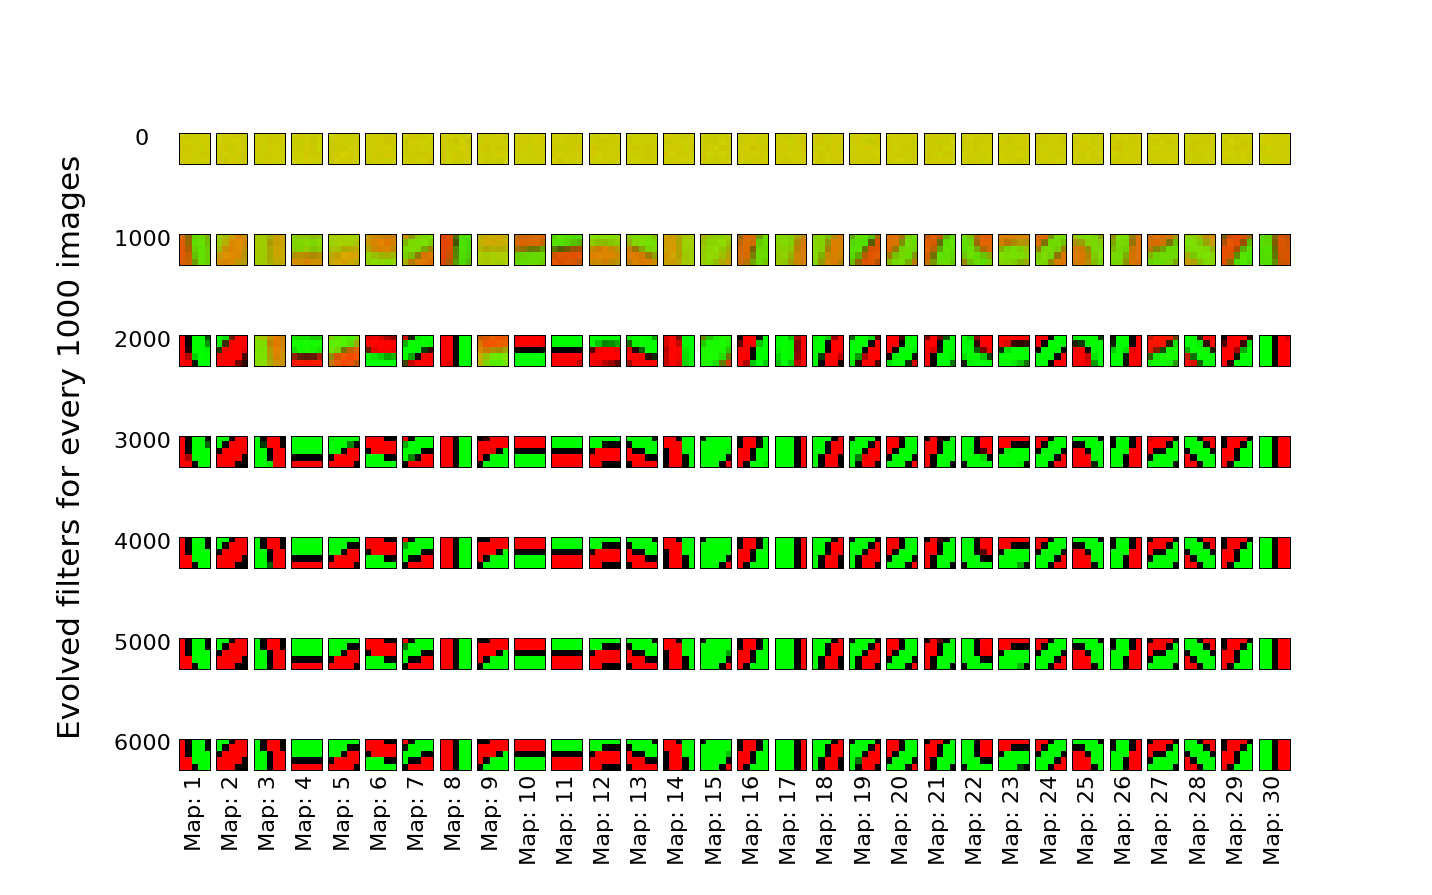

In [5]:
nofImages = 6000
new_sample_interval=1000
new_intervals = nofImages/new_sample_interval
skips = new_sample_interval/sample_interval
fig = net1.feature_visualization([net1.evol_weights[::skips]], new_sample_interval, new_intervals,\
                                 figsize=(16,10), font1=18, font2=25)
#fig.subplots_adjust(left=0.12,right=0.89, bottom=0.05, top=1.0, hspace=0.42, wspace=0.08)


## Animate the evolution of filters

<IPython.core.display.Javascript object>


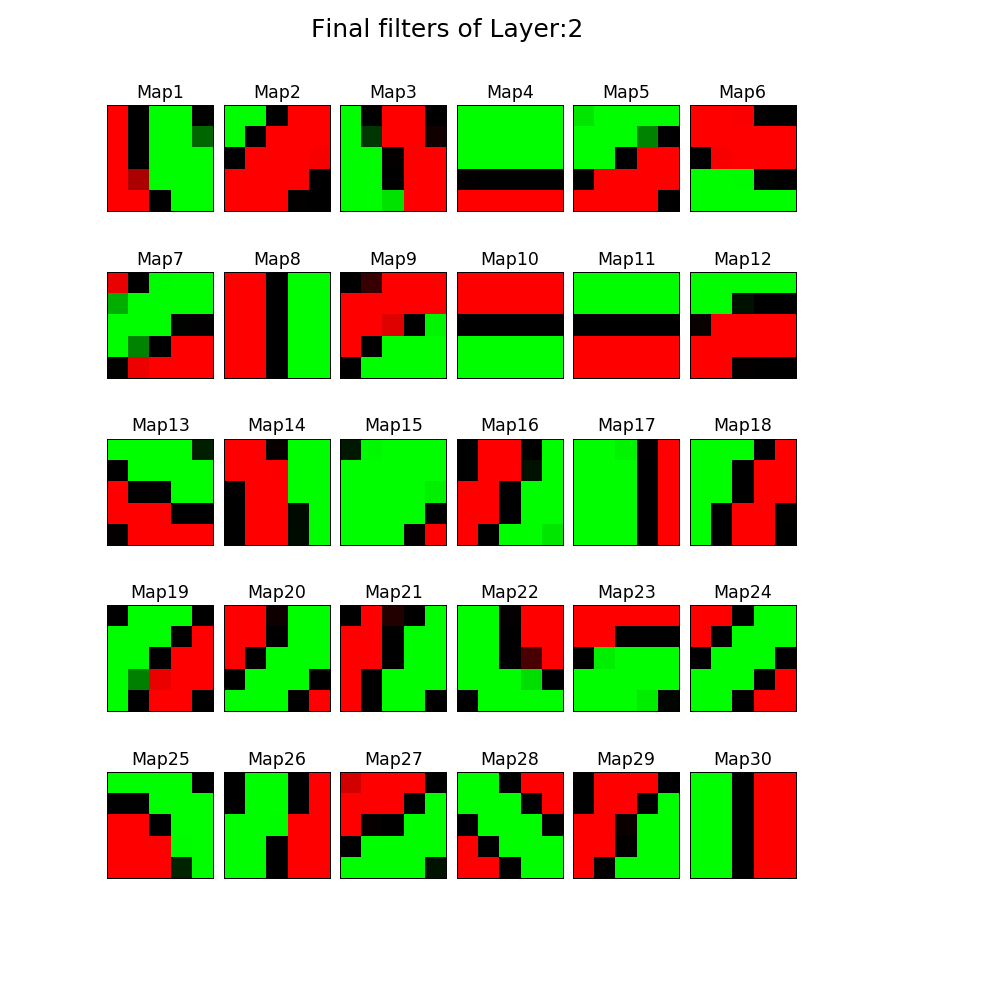

In [7]:
animation, fig = net1.animation([net1.evol_weights], plotx=5, ploty=6, sample_interval=sample_interval,\
                                intervals=intervals, currLayer=2)

In [8]:
HTML(animation.to_html5_video())

## Feature convergence of L2 layer

<IPython.core.display.Javascript object>


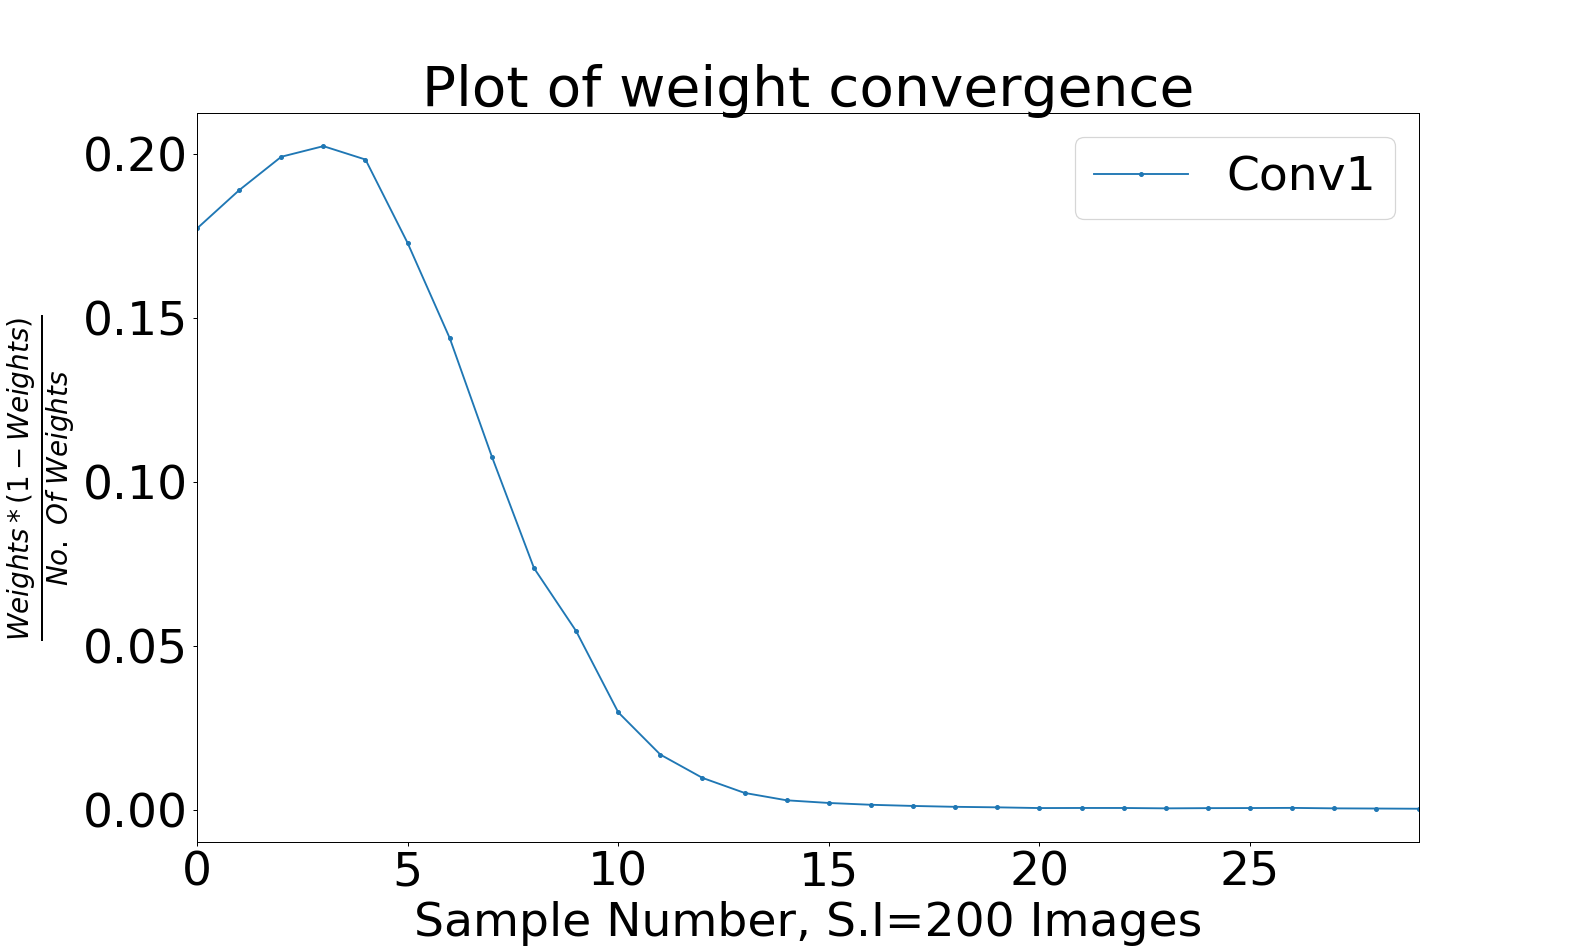

<IPython.core.display.Javascript object>


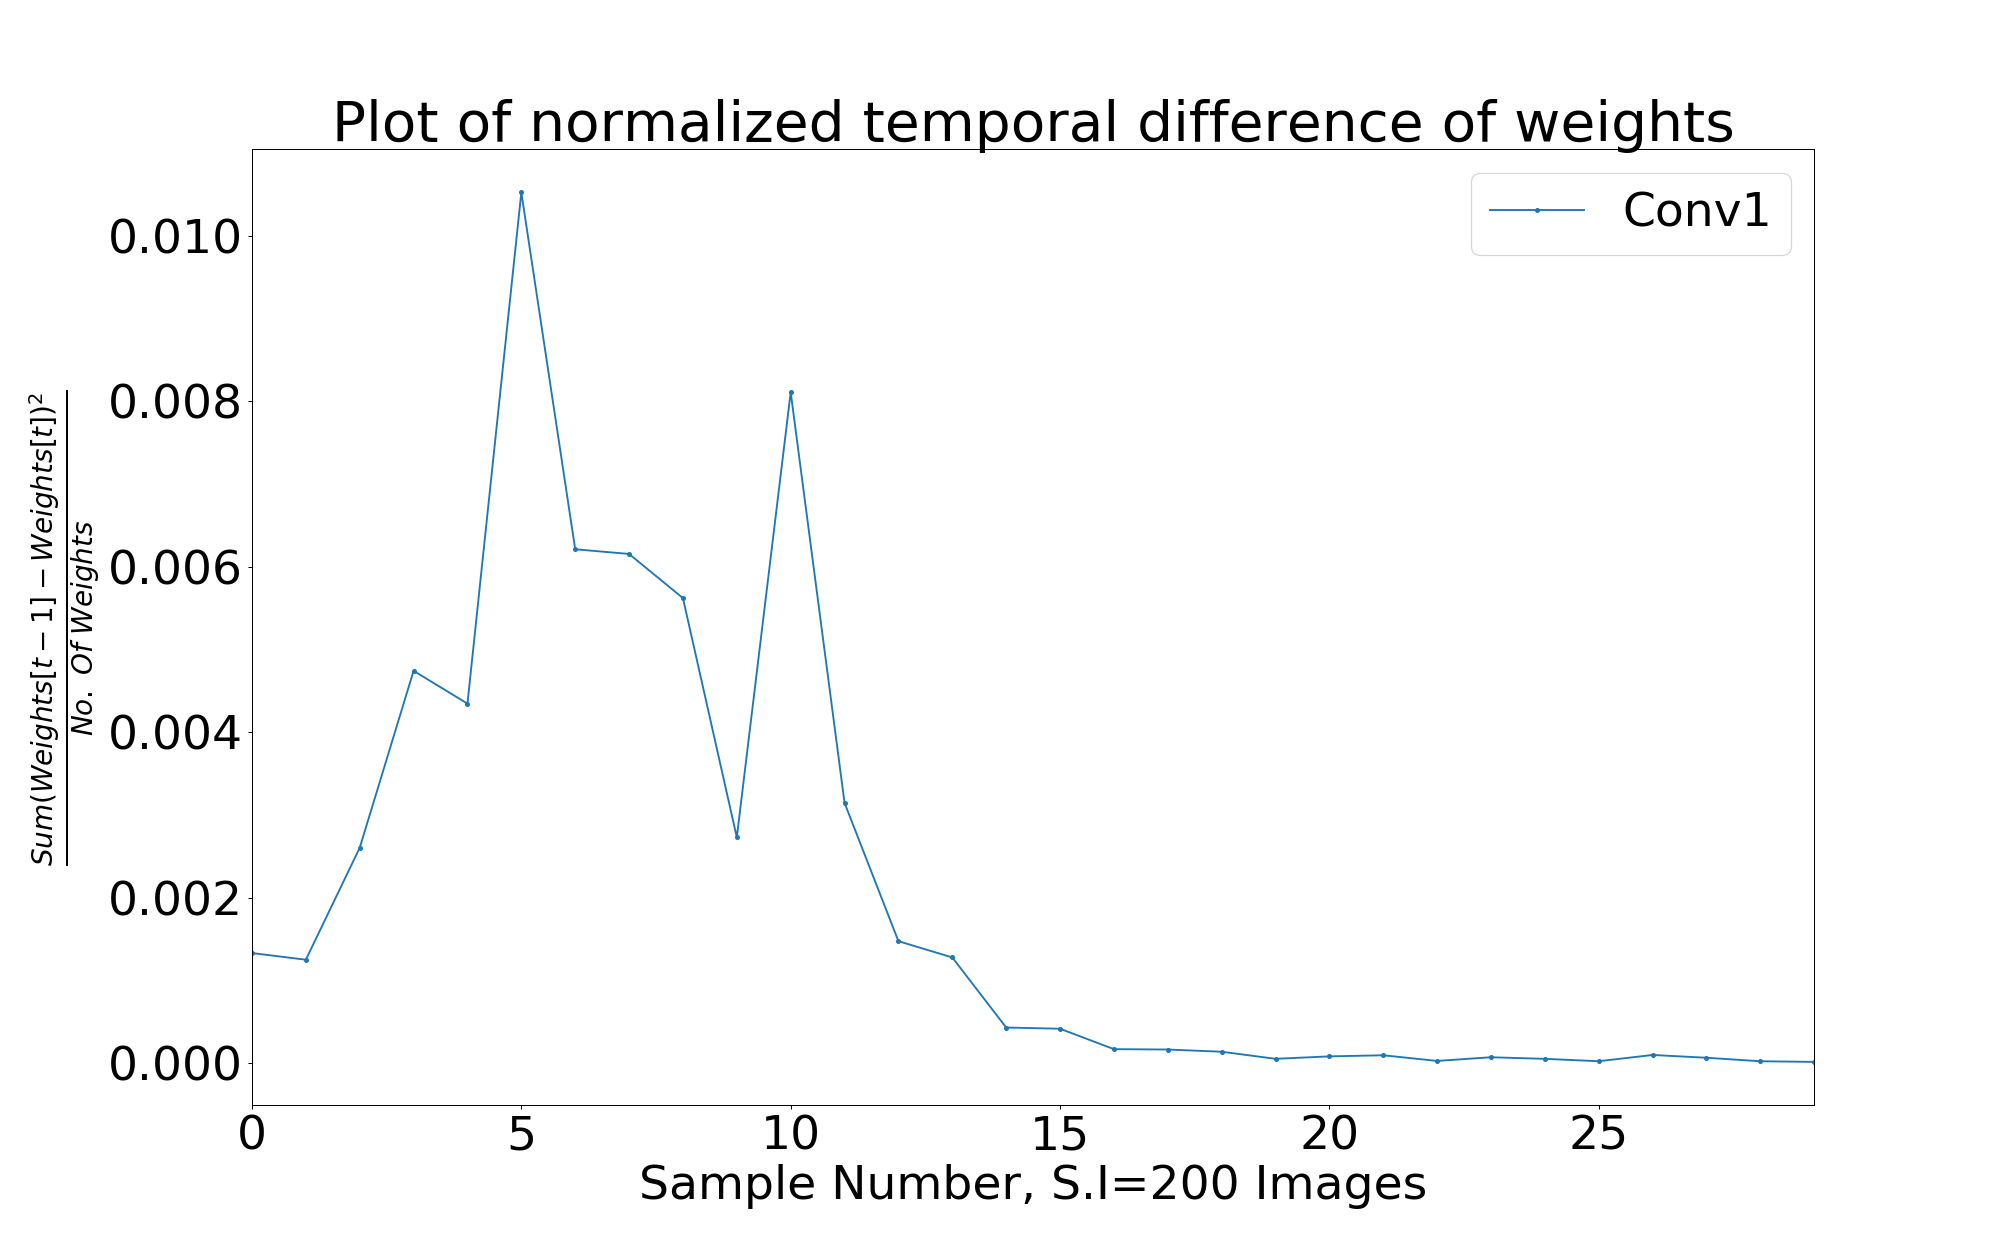

In [15]:
net1.feature_convergence([net1.evol_weights], sample_interval)

## Spike statistics of L2 layer

<IPython.core.display.Javascript object>


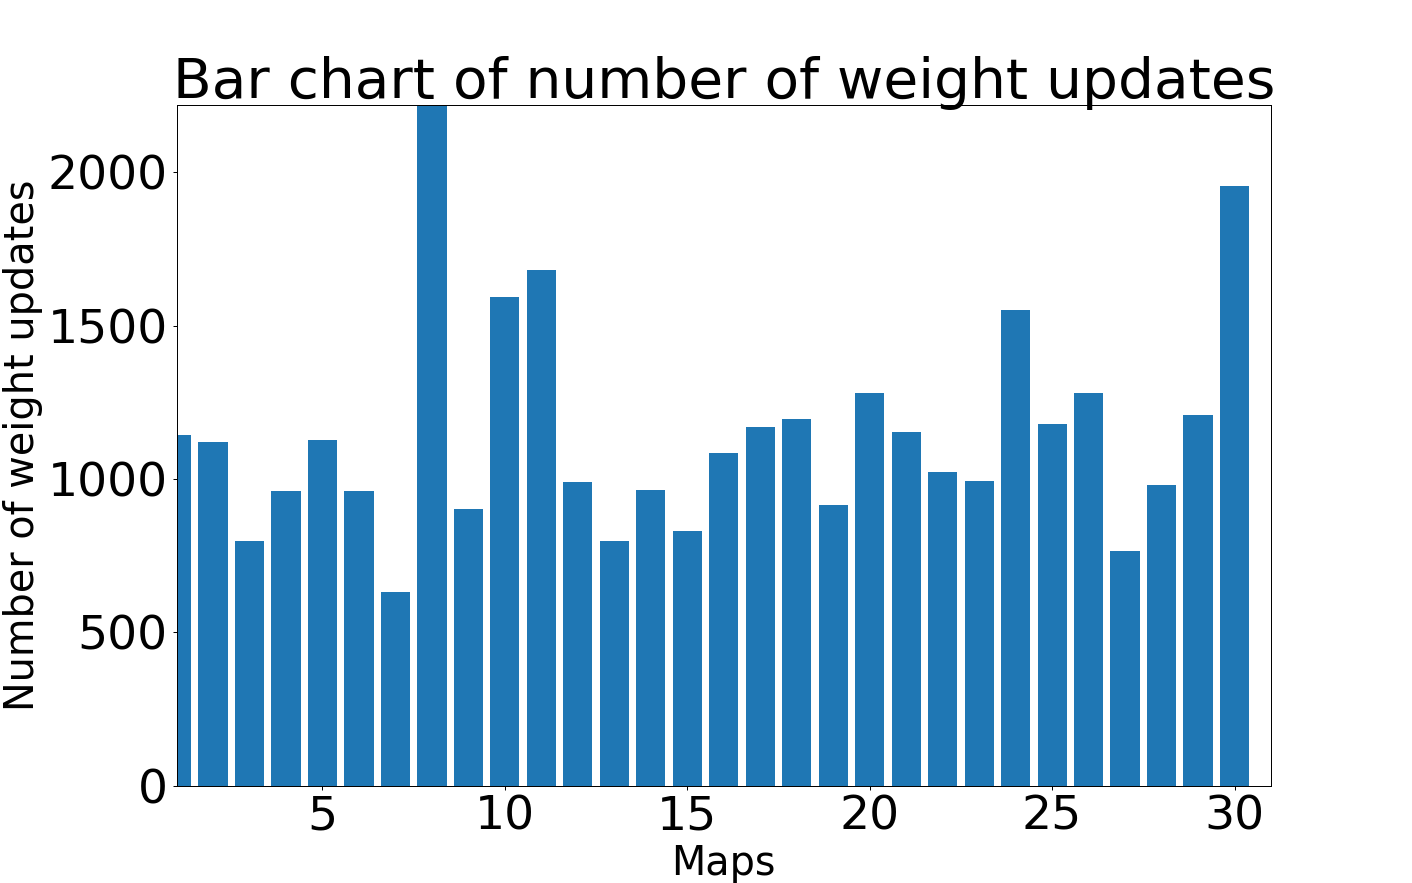

<IPython.core.display.Javascript object>


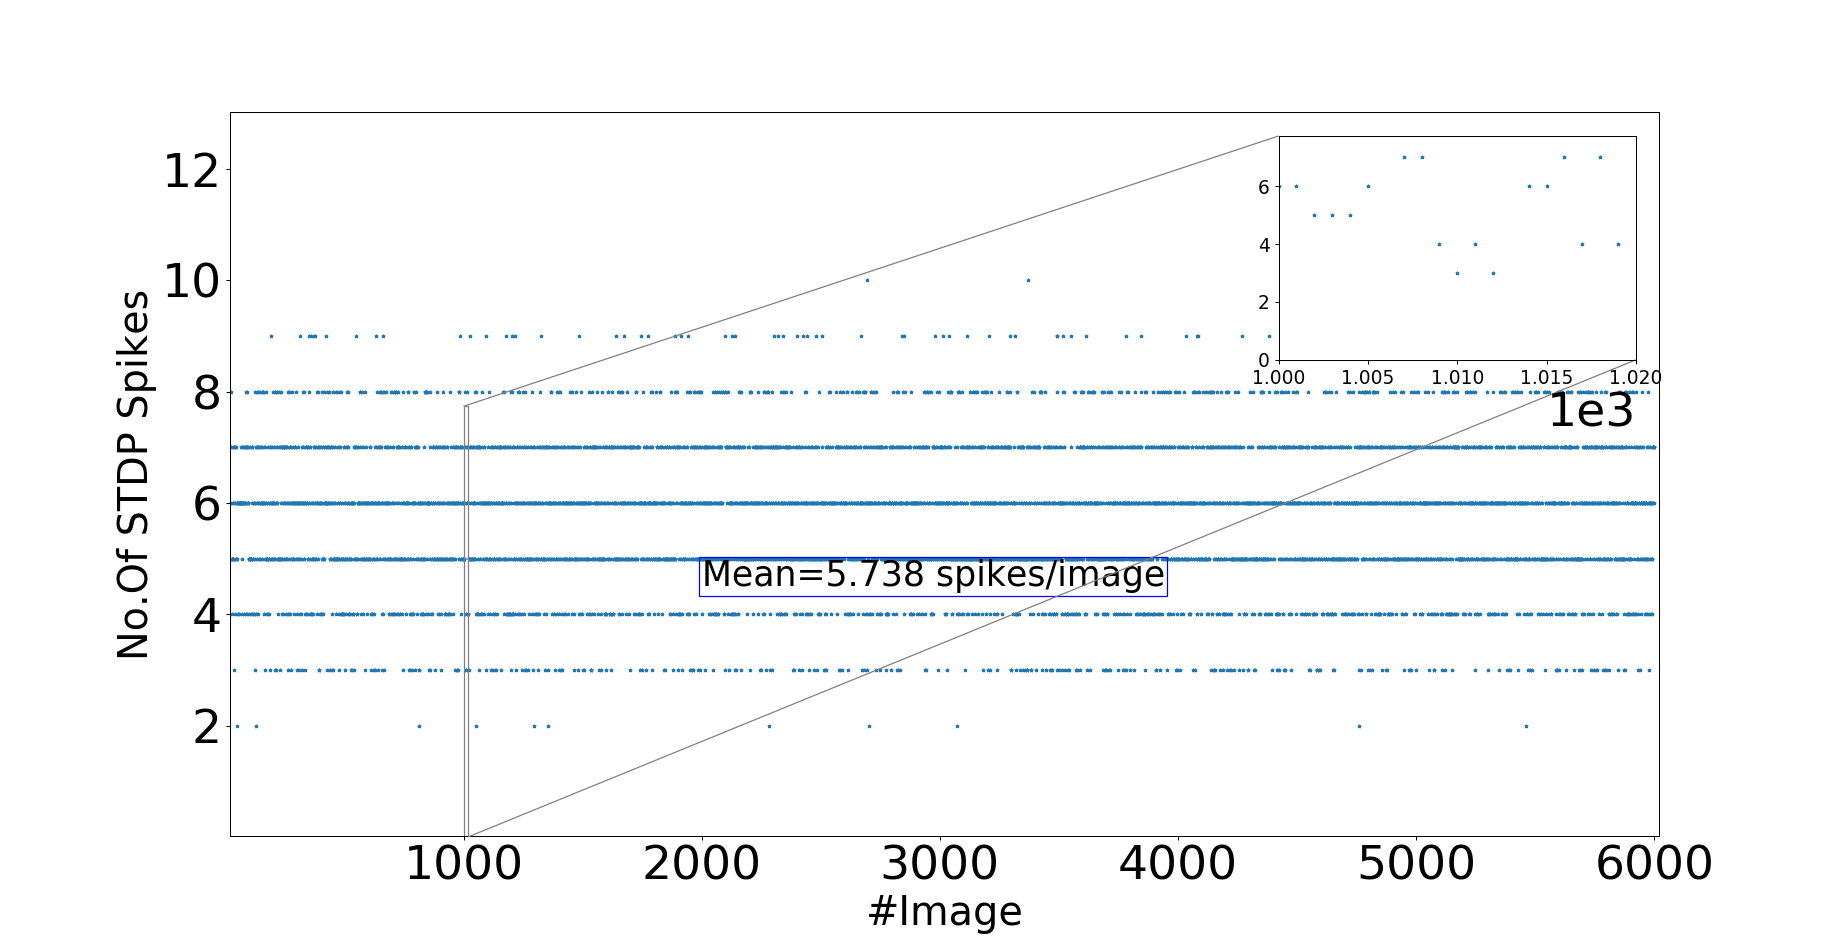

In [13]:
net1.spike_statistics()

# Fix the weights of L2 and collect spikes in pool1 (L3)
* Collect spikes in L3 without enforcing lateral inhbition in L3 and limiting number of spikes per neuron per image to one by setting `pool_lateral_inh=False ` and `pool_spike_accum=False` respectively.
* Collected spikes can be used to train the subsequent convolution layers or create feature vectors 
* At this stage **only lateral inhibition** is applied in L2 and **no STDP competition is applied** as learning is already done.

In [14]:
evolved_weights = net1.evol_weights[-1]
pool1_lateral =  False
net2 = network.Network(homeostasis_const=5, factor=5.0, pool_lateral_inh=pool1_lateral, inputs=train_input_images,\
                       output_channels=l1_maps,A_plus=0.002, train=False, set_weights=evolved_weights, debug=False,\
                       save_pool_spike_tensor=True,save_pool_features=True, threshold=15.0, pool_spike_accum=False)
net2.rewire_weights() ## fixing the weights
net2.feedforward()

Setting up the synapses and the weights

connections of first neuron in the maps to neurons in input image(prev_map):
[  0   1   2   3   4  27  28  29  30  31  54  55  56  57  58  81  82  83
  84  85 108 109 110 111 112]

connections of last neuron in the maps to neurons in input image(prev_map):
[616 617 618 619 620 643 644 645 646 647 670 671 672 673 674 697 698 699
 700 701 724 725 726 727 728]

There are:(27, 27) neurons in each of the input map and there are:25 synapses from previous maps going into each        neuron of the input map and there are:2 previous maps and there are:30 input maps


Epoch:0 is done!


## Plot spikes per map per label in L3

<IPython.core.display.Javascript object>


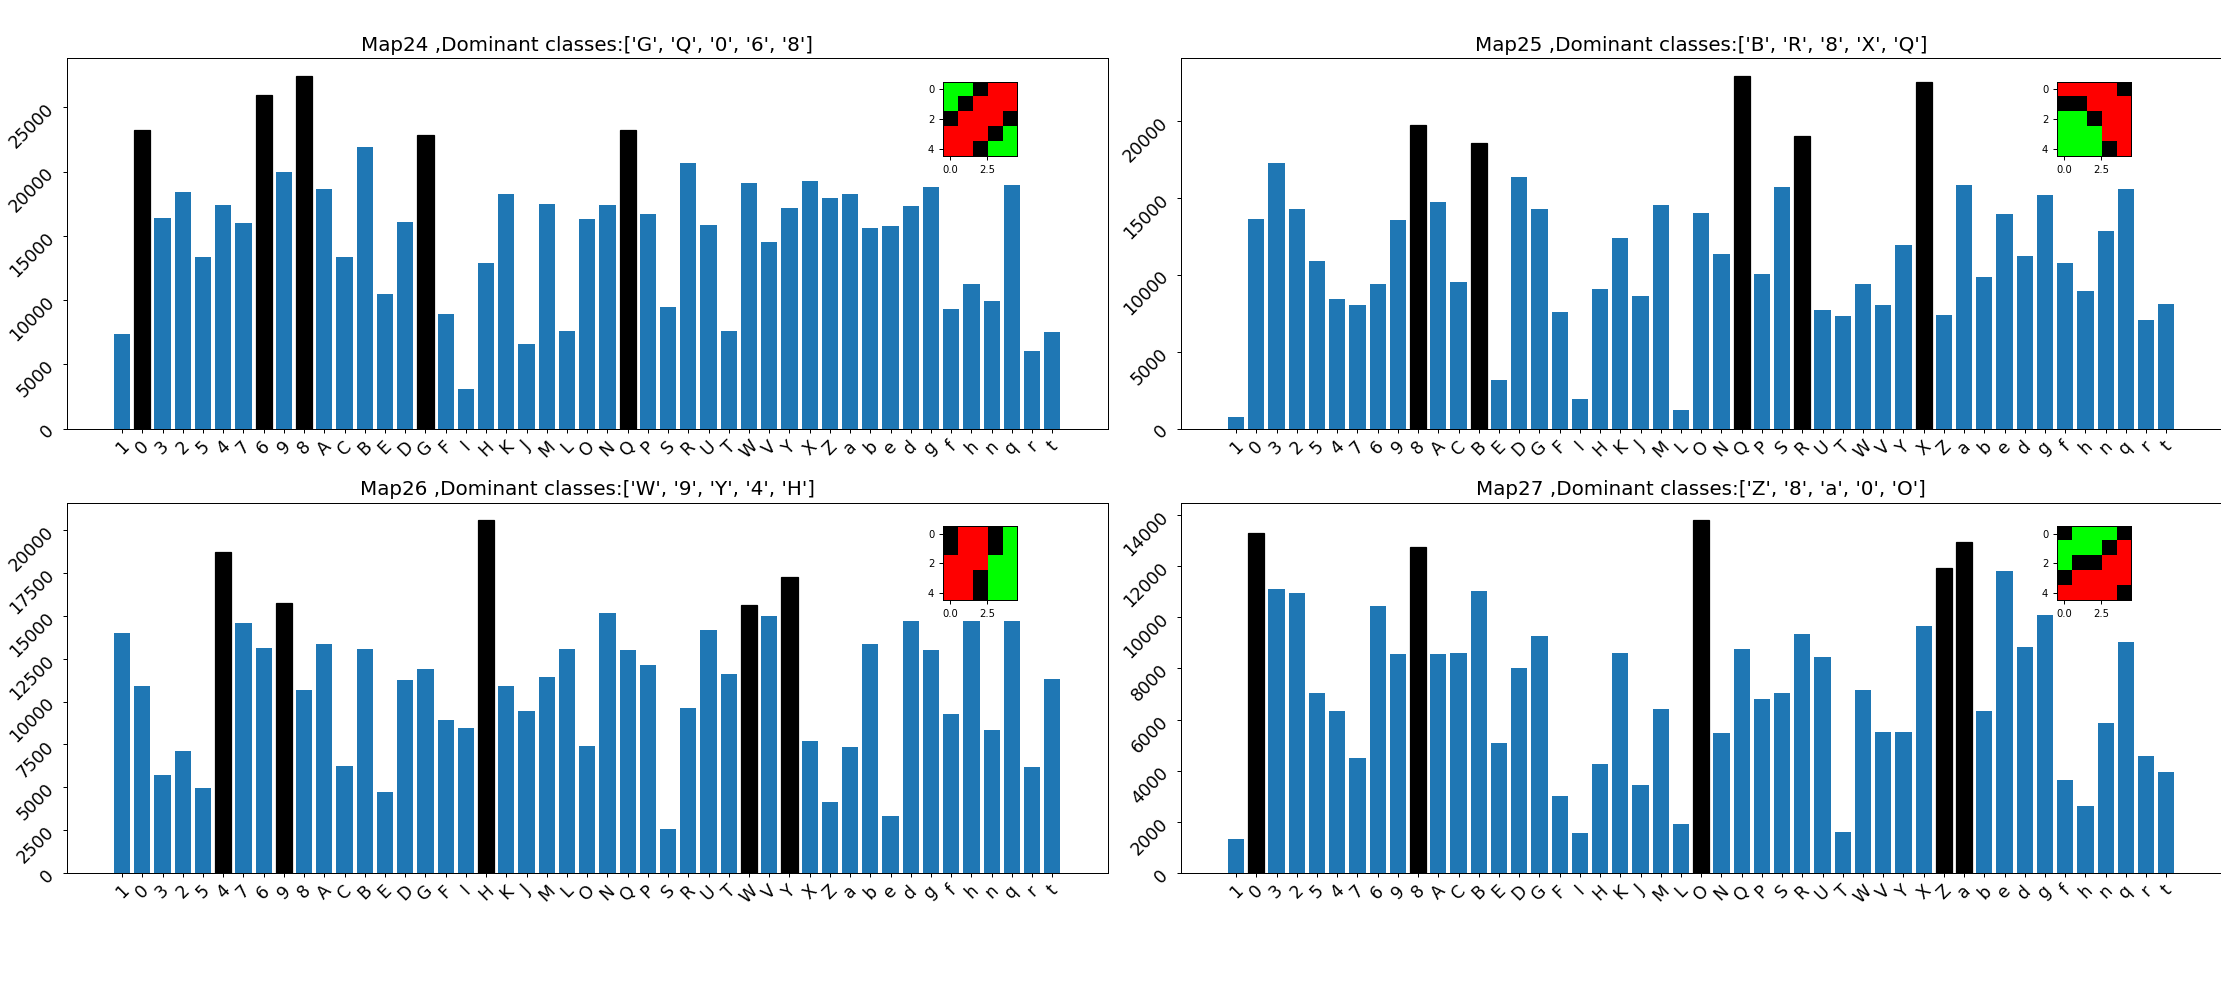

727766
[7389, 23271, 16363, 18437, 13327, 17400, 16038, 25930, 19947, 27445, 18678, 13349, 21884, 10443, 16109, 22835, 8888, 3095, 12866, 18234, 6599, 17477, 7614, 16318, 17375, 23250, 16680, 9504, 20679, 15826, 7633, 19113, 14502, 17193, 19262, 17968, 18273, 15625, 15804, 17322, 18810, 9312, 11247, 9918, 18954, 6030, 7550]
544275
[735, 13608, 17283, 14239, 10859, 8412, 8029, 9426, 13543, 19720, 14717, 9516, 18541, 3142, 16330, 14299, 7576, 1923, 9092, 12391, 8612, 14553, 1202, 13995, 11323, 22903, 10055, 15691, 19011, 7728, 7316, 9386, 8041, 11933, 22509, 7404, 15820, 9846, 13958, 11210, 15206, 10731, 8911, 12827, 15588, 7048, 8087]
520825
[13978, 10911, 5724, 7138, 4987, 18747, 14579, 13112, 15754, 10700, 13339, 6236, 13072, 4743, 11264, 11881, 8940, 8468, 20576, 10902, 9475, 11432, 13099, 7421, 15164, 13019, 12139, 2591, 9644, 14166, 11639, 15666, 14981, 17254, 7675, 4117, 7341, 13363, 3326, 14711, 12984, 9290, 14707, 8351, 14719, 6169, 11331]
346768
[1330, 13297, 11101, 10950, 7040

In [16]:
fig = net2.spikes_per_map_per_class(plot_x=2,plot_y=2,class_labels=class_labels_train,pool_output_data=net2.pool_spike_tensor,\
                                  labels_map=labels_map, labelsize=14, view_maps=[24,25,26,27], final_weights=net1.evol_weights[-1])


In [30]:
print('Shape of spike tensor:{}'.format(net2.pool_spike_tensor.shape))
nSpikesL3 = net2.pool_spike_tensor.sum()
print('Average spikes per image:{}'.format(nSpikesL3/(train_input_images.shape[-1]/12)))

Shape of spike tensor:(11, 11, 30, 1353588)
Average spikes per image:154


### Create feature vectors
* These feature vectors along with labels can be saved to pickle file and passed to a classifier..

`h5file = 'features_labels'+'.h5'
 with h5py.File(h5file, 'w') as hf: 
     hf.create_dataset("l3_spike_features_labels",  data = [train_pool_spike_features, class_labels_train])
 print "pool1 train spike features .h5 file written to",h5file`

In [36]:
net2.pool_spike_features.shape

(11, 11, 30, 112799)

In [29]:
train_pool_spike_features = net2.make_feature_vecs(net2.pool_spike_features)
train_pool_pot_features = net2.make_feature_vecs(net2.pool_pot_features)
temp = train_pool_spike_features.sum(axis=1)
L3avgSpikes = temp.mean()
print('Average spikes per image:{}'.format(L3avgSpikes))

Average spikes per image:154.1102758


# Fix the weights of L2 and collect spikes in pool1 (L3)
* Collect spikes in L3 with enforcing lateral inhbition in L3 and limiting number of spikes per neuron per image to one by setting `pool_lateral_inh=True ` and `pool_spike_accum=False` respectively.
* Collected spikes can be used to train the subsequent convolution layers or create feature vectors.
* At this stage **only lateral inhibition** is applied in L2 and **no STDP competition is applied** as learning is already done.

In [31]:
evolved_weights = net1.evol_weights[-1]
pool1_lateral =  True
evolved_weights = net1.evol_weights[-1]
net3 = network.Network(homeostasis_const=5, factor=5.0, pool_lateral_inh=pool1_lateral, inputs=train_input_images, output_channels=l1_maps,\
                       A_plus=0.002, train=False, set_weights=evolved_weights, debug=False, save_pool_spike_tensor=True,\
                       save_pool_features=False, threshold=15.0)
net3.rewire_weights() ## fixing the weights
net3.feedforward()

Setting up the synapses and the weights

connections of first neuron in the maps to neurons in input image(prev_map):
[  0   1   2   3   4  27  28  29  30  31  54  55  56  57  58  81  82  83
  84  85 108 109 110 111 112]

connections of last neuron in the maps to neurons in input image(prev_map):
[616 617 618 619 620 643 644 645 646 647 670 671 672 673 674 697 698 699
 700 701 724 725 726 727 728]

There are:(27, 27) neurons in each of the input map and there are:25 synapses from previous maps going into each        neuron of the input map and there are:2 previous maps and there are:30 input maps


Epoch:0 is done!


## Plot spikes per map per class

<IPython.core.display.Javascript object>


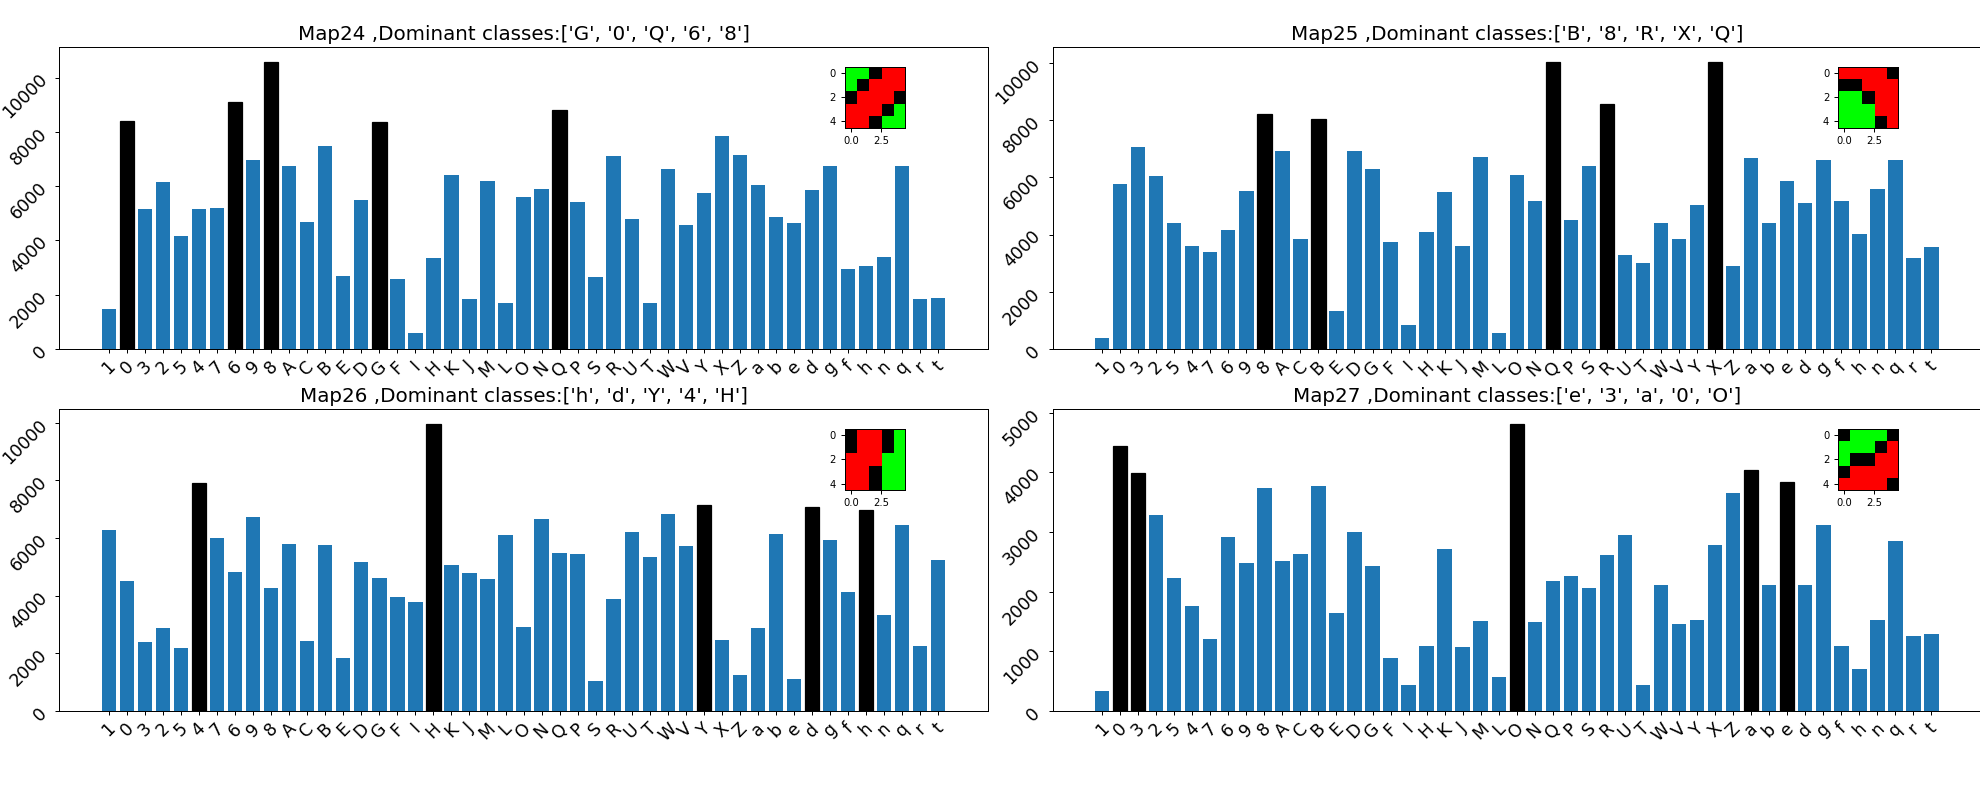

242346
[1489, 8402, 5170, 6136, 4154, 5149, 5194, 9105, 6974, 10587, 6754, 4663, 7462, 2696, 5492, 8369, 2572, 585, 3348, 6407, 1855, 6190, 1700, 5612, 5885, 8815, 5423, 2646, 7117, 4786, 1679, 6649, 4577, 5750, 7857, 7144, 6058, 4866, 4633, 5849, 6735, 2936, 3070, 3371, 6740, 1833, 1862]
237046
[369, 5772, 7061, 6040, 4418, 3604, 3389, 4174, 5529, 8225, 6918, 3843, 8030, 1318, 6929, 6285, 3738, 823, 4099, 5478, 3592, 6702, 557, 6092, 5170, 10042, 4523, 6411, 8574, 3292, 3006, 4407, 3833, 5031, 10016, 2913, 6686, 4412, 5888, 5118, 6613, 5166, 4018, 5581, 6619, 3170, 3572]
223738
[6276, 4520, 2393, 2890, 2171, 7906, 6011, 4822, 6726, 4258, 5808, 2413, 5758, 1841, 5155, 4617, 3942, 3768, 9966, 5067, 4793, 4575, 6111, 2903, 6646, 5469, 5457, 1038, 3898, 6214, 5329, 6841, 5724, 7131, 2477, 1249, 2889, 6148, 1120, 7089, 5936, 4140, 6972, 3315, 6454, 2258, 5254]
104898
[335, 4436, 3995, 3281, 2233, 1757, 1203, 2924, 2473, 3737, 2512, 2638, 3776, 1643, 3000, 2430, 885, 441, 1097, 2712, 1066, 

In [32]:
fig = net3.spikes_per_map_per_class(plot_x=2,plot_y=2,class_labels=class_labels_train,pool_output_data=net3.pool_spike_tensor,\
                                  labels_map=labels_map, labelsize=14, view_maps=[24,25,26,27], final_weights=net1.evol_weights[-1])


In [33]:
print('Shape of spike tensor:{}'.format(net3.pool_spike_tensor.shape))
nSpikesL3 = net3.pool_spike_tensor.sum()
print('Average spikes per image:{}'.format(nSpikesL3/(train_input_images.shape[-1]/12)))

Shape of spike tensor:(11, 11, 30, 1353588)
Average spikes per image:61


### Create feature vectors
* We can't obtain spike feature vectors from `spikeflow` for the object `net3` because we set `save_pool_features=False`. However, we have access to `net3.pool_spike_tensor` so we can create features we can write some custom code

In [ ]:
train_pool_spike_features = net3.make_feature_vecs(net3.pool_spike_features)
train_pool_pot_features = net3.make_feature_vecs(net3.pool_pot_features)
temp = train_pool_spike_features.sum(axis=1)
L3avgSpikes = temp.mean()
print('Average spikes per image:{}'.format(L3avgSpikes))

# Train Conv2 (L4) with spikes collected from L3 
* Here, we use spikes that were collected in L3 without lateral inhibition

In [37]:
l4_maps = 200
pool2_lateral = False
size = net2.pool_spike_tensor.shape[0]
input_channels = net2.pool_spike_tensor.shape[2]
lr_inc_rate = 1500
nTrain_images = 35000 ##35k is enough if lateral inh in pool1 is False
net4 = network.Network(homeostasis_const=3,factor=3.0,pool_lateral_inh= pool2_lateral,inputs=net2.pool_spike_tensor[:,:,:,0:nTrain_images*tsteps],\
                       A_plus=0.0002,debug=False, output_channels=l4_maps, size=size, input_channels=input_channels,\
                       lr_inc_rate=lr_inc_rate,sample_interval=sample_interval,train=True,threshold=15.0,inh_reg=3,homeo_supp_coeff=0.0003,\
                       epochs=1)

net4.feedforward()

Setting up the synapses and the weights

connections of first neuron in the maps to neurons in input image(prev_map):
[ 0  1  2  3  4 11 12 13 14 15 22 23 24 25 26 33 34 35 36 37 44 45 46 47
 48]

connections of last neuron in the maps to neurons in input image(prev_map):
[ 72  73  74  75  76  83  84  85  86  87  94  95  96  97  98 105 106 107
 108 109 116 117 118 119 120]

There are:(11, 11) neurons in each of the input map and there are:25 synapses from previous maps going into each        neuron of the input map and there are:30 previous maps and there are:200 input maps
Images trained so far:1
current A_plus:0.0004, A_minus:0.0003, tstep:0, epoch:0


Images trained so far:1500
current A_plus:0.0008, A_minus:0.0006, tstep:17999, epoch:0


Images trained so far:3000
current A_plus:0.0016, A_minus:0.0012, tstep:35998, epoch:0


Images trained so far:4500
current A_plus:0.0032, A_minus:0.0024, tstep:53997, epoch:0


Images trained so far:6000
current A_plus:0.0064, A_minus:0.0048, tstep:71996, epoch:0


Images trained so far:7500
current A_plus:0.0128, A_minus:0.0096, tstep:89995, epoch:0


Images trained so far:9000
current A_plus:0.0256, A_minus:0.0192, tstep:107994, epoch:0


Images trained so far:10500
current A_plus:0.0512, A_minus:0.0384, tstep:125993, epoch:0


Images trained so far:12000
current A_plus:0.1024, A_minus:0.0768, tstep:143992, epoch:0


Images trained so far:13500
current A_plus:0.15, A_minus:0.1125, tstep:161991, epoch:0


Images trained so far:15000
current A_plus:0.15, A_minus:0.1125, tstep:179990, epoch:0


Images trained so far:16500
current A_plus:0.15, A_minus:0.1125, tstep:197989, epoch:0


Images trained so far:18000
current A_plus:0.15, A_minus:0.1125, tstep:215988, epoch:0


Images trained so far:19499
current A_plus:0.15, A_minus:0.1125, tstep:233987, epoch:0


Images trained so far:20999
current A_plus:0.15, A_minus:0.1125, tstep:251986, epoch:0


Images trained so far:22499
current A_plus:0.15, A_minus:0.1125, tstep:269985, epoch:0


Images trained so far:23999
current A_plus:0.15, A_minus:0.1125, tstep:287984, epoch:0


Images trained so far:25499
current A_plus:0.15, A_minus:0.1125, tstep:305983, epoch:0


Images trained so far:26999
current A_plus:0.15, A_minus:0.1125, tstep:323982, epoch:0


Images trained so far:28499
current A_plus:0.15, A_minus:0.1125, tstep:341981, epoch:0


Images trained so far:29999
current A_plus:0.15, A_minus:0.1125, tstep:359980, epoch:0


Images trained so far:31499
current A_plus:0.15, A_minus:0.1125, tstep:377979, epoch:0


Images trained so far:32999
current A_plus:0.15, A_minus:0.1125, tstep:395978, epoch:0


Images trained so far:34499
current A_plus:0.15, A_minus:0.1125, tstep:413977, epoch:0


Epoch:0 is done!


## Feature convergence plot

<IPython.core.display.Javascript object>


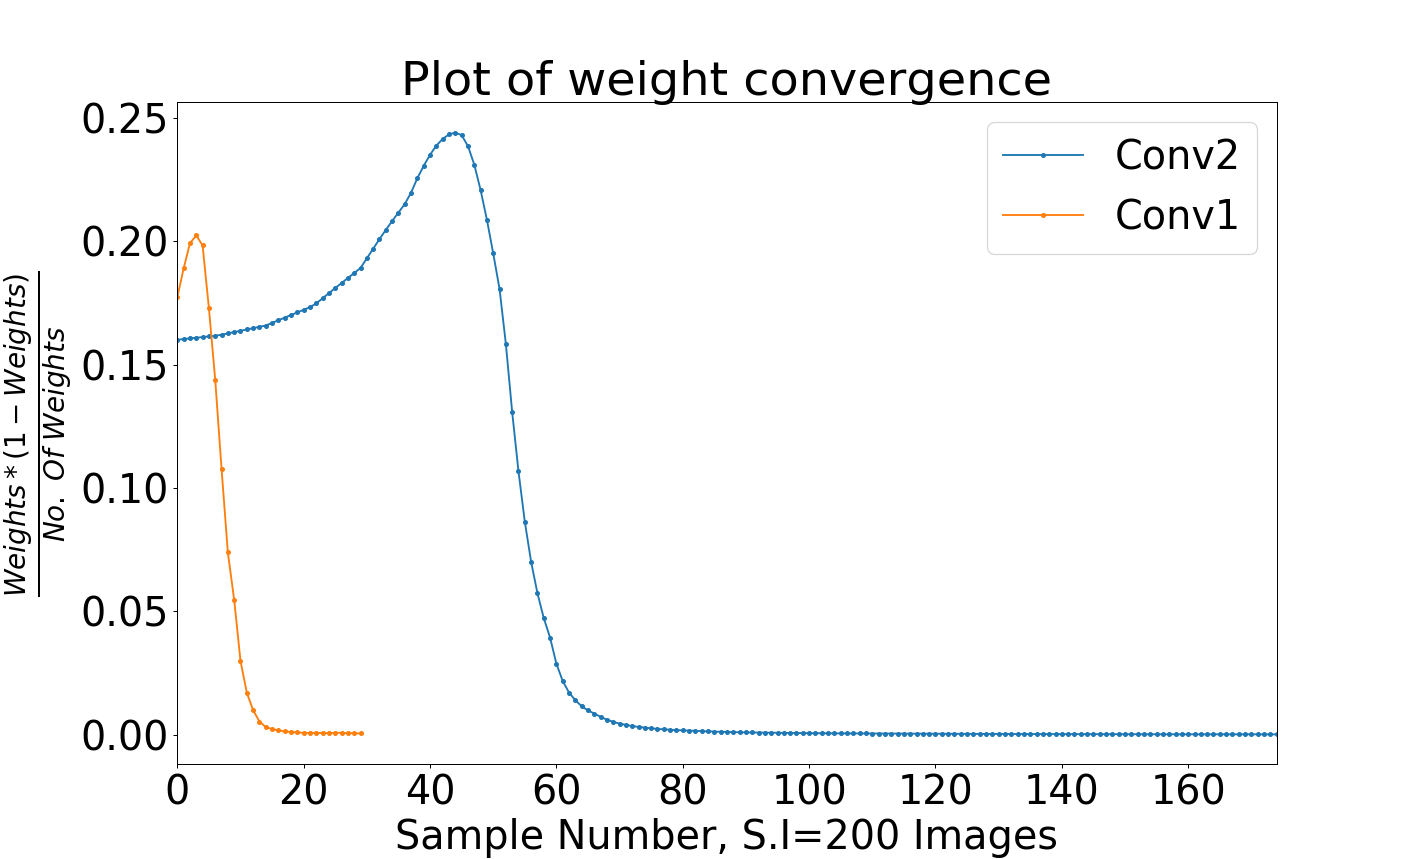

<IPython.core.display.Javascript object>


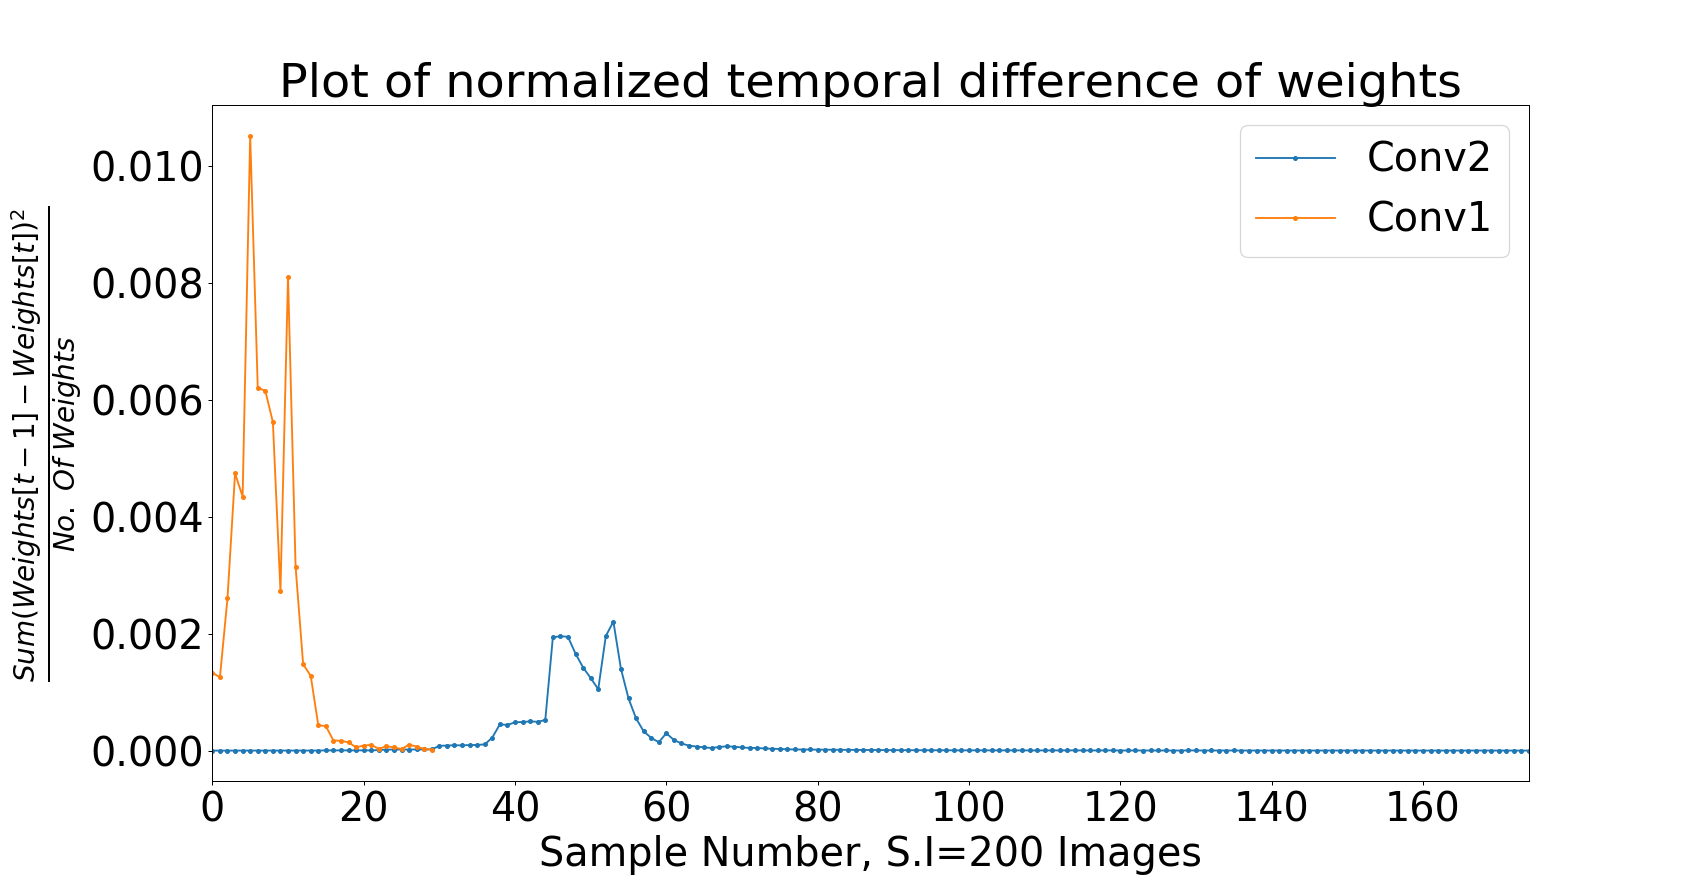

In [38]:
net4.feature_convergence([net1.evol_weights, net4.evol_weights],sample_interval)

## Feature visualization

<IPython.core.display.Javascript object>


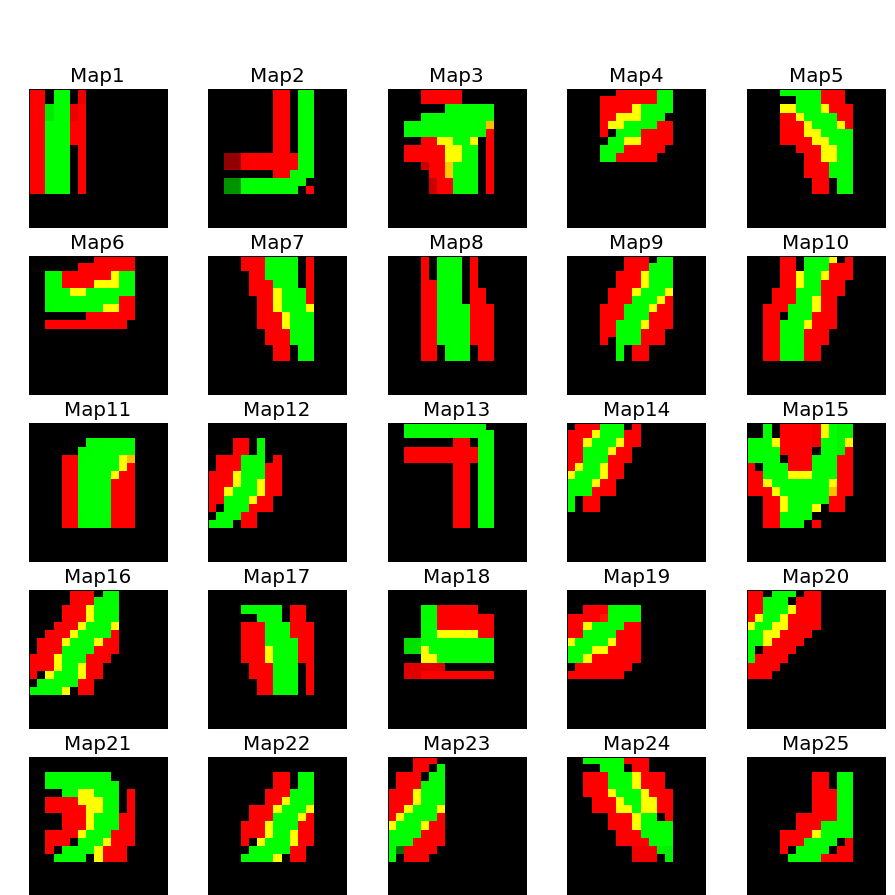

In [39]:
layer_num = [2,3,4]
filter_sizes = [net2.conv_kernel_size,net2.pool_kernel_size,net4.conv_kernel_size] ##[list of synapses from  first to last layers]
filter_strides = [1,2,1]
nof_filters = [net2.output_channels,net2.output_channels,net4.output_channels] ##[list of number of filters from first to last layers]
types = ['conv','pool','conv']
currLayer= 4
layer_weights=[[net2.evol_weights],[net4.evol_weights]]
fig = net4.feature_visualization(layer_weights,sample_interval,intervals,plotx=5,ploty=5,layer_num=layer_num,\
                          filter_sizes=filter_sizes,filter_strides=filter_strides,nof_filters=nof_filters,\
                          types=types,currLayer=currLayer,show=True)

## Feature animation

In [40]:
animation, fig = net4.animation(layer_weights,sample_interval,intervals,plotx=10,ploty=10,layer_num=layer_num,\
                              filter_sizes=filter_sizes,filter_strides=filter_strides,nof_filters=nof_filters,\
                              types=types,currLayer=currLayer)

UnboundLocalError: local variable 'fig' referenced before assignment

In [ ]:
HTML(animation.to_html5_video())